In [ ]:
import pandas as pd

df_subject_ids = [1,2,4,5,6,7,8,9,10,11,12,13]
# df_subject_ids = [1,2]
gesture_ids =[1,3]

list_of_list_of_dfs =[]


def load_data():
  for subject_id in df_subject_ids:
    row_of_dfs = []
    for gesture_id in gesture_ids:
      sub_row_of_rows=[]
      sgnl_df = pd.read_csv(f"/content/drive/MyDrive/smith_datasets/sEmg_fatigue/sEmg_fatigue_small/subject_{subject_id}/trial_{gesture_id}.csv")
      fat_df = pd.read_csv(f"/content/drive/MyDrive/smith_datasets/sEmg_fatigue/self_perceived_fatigue_index/subject_{subject_id}/subject_{subject_id}/trial_{gesture_id}.csv")

      sub_row_of_rows.append(sgnl_df)
      sub_row_of_rows.append(fat_df)

      row_of_dfs.append(sub_row_of_rows)

    list_of_list_of_dfs.append(row_of_dfs)


In [ ]:
load_data()

In [ ]:
list_of_list_of_dfs[1][1][0].columns
#[subject][trail/gesture(0->t1,1->t3)][signal(0)/fatigue(1)]
# all index starts from 0

Index(['X [s]', 'R BICEPS BRACHII: EMG 1 [V]', 'X [s].1',
       'R DELTOID ANTERIOR: EMG 2 [V]', 'X [s].5',
       'R DELTOID MEDIUS: EMG 6 [V]', 'X [s].6',
       'R DELTOID POSTERIOR: EMG 7 [V]'],
      dtype='object')

Plotting the Raw sEMG signal of a Muscle and make marks at when fatigue starts.
- Fatigue level 1 starts after dotted line mark
- Fatigue level 2 starts after dashed line mark

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the Raw sEMG signal of a Muscle and make marks at when fatigue starts.
def plot_signal_with_fatigue_mark(plot_ax,signal_dataframe, fatigue_dataframe, signal_dataframe_muscle_column,color='blue'):

  x = signal_dataframe["X [s]"].values
  y = signal_dataframe[signal_dataframe_muscle_column].values #"R BICEPS BRACHII: EMG 1 [V]"

  plot_ax.plot(x,y, color=color,alpha=0.75)

  def mark_fatigues( signal , fatigue_df, label , color='black',line_style='--'):
    mask = fatigue_df['label'] == label
    first_time = fatigue_df.loc[mask, 'time'].iloc[0] if mask.any() else None

    nearest_index_fat_mark = np.abs(signal - first_time).argmin()
    nearest_x_value_fat_mark = signal[nearest_index_fat_mark]
    plot_ax.axvline(x=nearest_x_value_fat_mark, color=color, linestyle=line_style)


  mark_fatigues(x,fatigue_dataframe,1,color,':')
  mark_fatigues(x,fatigue_dataframe,2,color,'--')

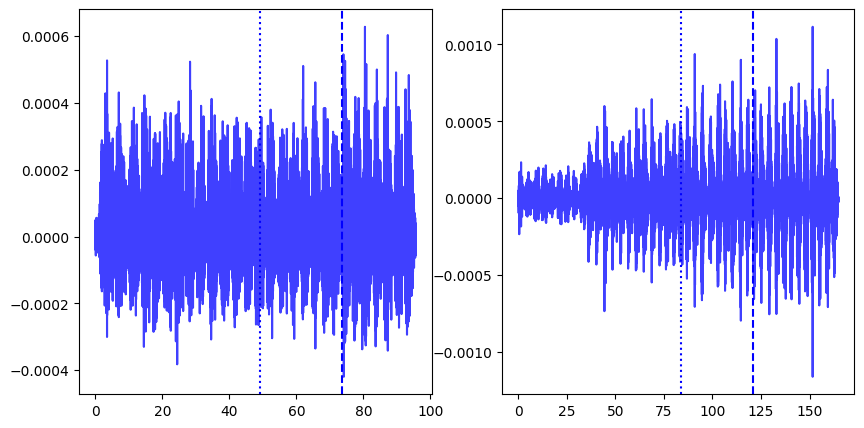

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()

plot_signal_with_fatigue_mark(axes[0],list_of_list_of_dfs[0][0][0],list_of_list_of_dfs[0][0][1],"R BICEPS BRACHII: EMG 1 [V]")
plot_signal_with_fatigue_mark(axes[1],list_of_list_of_dfs[1][0][0],list_of_list_of_dfs[1][0][1],"R BICEPS BRACHII: EMG 1 [V]")
plt.show()

In [ ]:
pip install emg-toolbox

Plotting the Calculated Feature of the sEMG signal of a Muscle and make marks at when fatigue starts.

Some parameters can be set, like :-
- Feature to be calculated
- Window time
- Muscle

In [ ]:
def plot_feature_signal_with_fatigue_mark(plot_ax,signal_dataframe, fatigue_dataframe, signal_dataframe_muscle_column , fs, window_time,feature_to_calc,color='blue'):

    def mark_fatigues( signal , fatigue_df, label , color='black',line_style='--'):
      mask = fatigue_df['label'] == label
      first_time = fatigue_df.loc[mask, 'time'].iloc[0] if mask.any() else None

      nearest_index_fat_mark = np.abs(signal - first_time).argmin()
      nearest_x_value_fat_mark = signal[nearest_index_fat_mark]
      plot_ax.axvline(x=nearest_x_value_fat_mark, color=color, linestyle=line_style)


    def sliding_window_scratch(feature_func,signal, window_size, overlap):
      step = window_size - overlap
      mav_values = []

      for start in range(0, len(signal) - window_size + 1, step):
        window = signal[start:start + window_size]
        feature_func_str = feature_func.__name__
        if (feature_func_str == 'fMF' or feature_func_str == 'fMPF' or feature_func_str == 'fSpectralEntropy'):
          mav = feature_func(window,fs)
        else:
          mav = feature_func(window)
        mav_values.append(mav)

      return np.array(mav_values)


    x = signal_dataframe["X [s]"].values
    y = signal_dataframe[signal_dataframe_muscle_column].values

    fs = fs                       # sampling frequency
    window_size = int(window_time * fs)   #
    overlap = window_size // 2     # 50% overlap

    mav_series = sliding_window_scratch(feature_to_calc,y, window_size, overlap)

    time = np.arange(len(mav_series)) * (window_size - overlap) / fs

    plot_ax.plot(time,mav_series,color=color,alpha=0.5)


    mark_fatigues(x,fatigue_dataframe,1,color,':')
    mark_fatigues(x,fatigue_dataframe,2,color,'--')


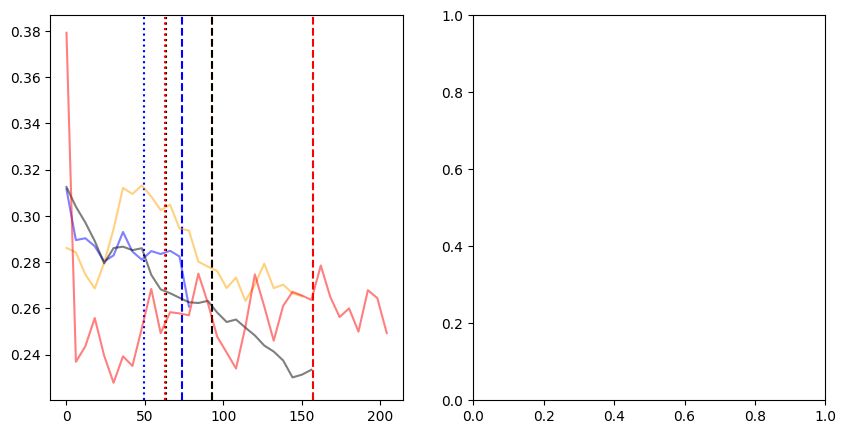

In [ ]:
import emg_toolbox.features as ef

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fs = 1259
window_time = 12 # Window time
feature_to_calc = ef.fSSC #Feature to be calculated

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()

#"R DELTOID ANTERIOR: EMG 2 [V]" is the muscle that was take here in the arguments of the function plot_feature_signal_with_fatigue_mark()

plot_feature_signal_with_fatigue_mark(axes[0],list_of_list_of_dfs[0][0][0], list_of_list_of_dfs[0][0][1], "R DELTOID ANTERIOR: EMG 2 [V]" , fs, window_time,feature_to_calc,'blue')
plot_feature_signal_with_fatigue_mark(axes[0],list_of_list_of_dfs[1][0][0], list_of_list_of_dfs[2][0][1], "R DELTOID ANTERIOR: EMG 2 [V]" , fs, window_time,feature_to_calc,'orange')
plot_feature_signal_with_fatigue_mark(axes[0],list_of_list_of_dfs[2][0][0], list_of_list_of_dfs[2][0][1], "R DELTOID ANTERIOR: EMG 2 [V]" , fs, window_time,feature_to_calc,'black')
plot_feature_signal_with_fatigue_mark(axes[0],list_of_list_of_dfs[3][0][0], list_of_list_of_dfs[3][0][1], "R DELTOID ANTERIOR: EMG 2 [V]" , fs, window_time,feature_to_calc,'red')

plt.show()

The below function calculates the Feature and returns calculated feature array and corresponding fatigue levels

In [ ]:
#DATASET BUILDING FOR TRANING ML MODEL

def build_col_with_corresponding_fatigue(signal,fatigue,feature,muscle,fs, window_time):

  def mark_fatigues( signal , fatigue_df, label, time_series_of_calculated_signal):
      mask = fatigue_df['label'] == label
      first_time = fatigue_df.loc[mask, 'time'].iloc[0] if mask.any() else None

      nearest_index_fat_mark = np.abs(signal - first_time).argmin()
      nearest_x_value_fat_mark = signal[nearest_index_fat_mark]

      nearest_index_of_fat_mark_in_feature_calculated_time_array = np.abs(time_series_of_calculated_signal - nearest_x_value_fat_mark).argmin()

      return(nearest_index_of_fat_mark_in_feature_calculated_time_array)


  def sliding_window_scratch(feature_func,signal, window_size, overlap):
      step = window_size - overlap
      mav_values = []

      for start in range(0, len(signal) - window_size + 1, step):
        window = signal[start:start + window_size]

        feature_func_str = feature_func.__name__
        if (feature_func_str == 'fMF' or feature_func_str == 'fMPF' or feature_func_str == 'fSpectralEntropy'):
          mav = feature_func(window,fs)
        else:
          mav = feature_func(window)
        mav_values.append(mav)
      return np.array(mav_values)

  x = signal["X [s]"].values
  y = signal[muscle].values

  fs = fs                       # sampling frequency
  window_size = int(window_time * fs)   #
  overlap = window_size // 2     # 50% overlap

  mav_series = sliding_window_scratch(feature,y, window_size, overlap)

  time_series_of_calculated_signal = np.arange(len(mav_series)) * (window_size - overlap) / fs

  fat_index_1_in_calculated_arr = mark_fatigues( x , fatigue, 1, time_series_of_calculated_signal)
  fat_index_2_in_calculated_arr = mark_fatigues( x , fatigue, 2, time_series_of_calculated_signal)

  # creating the fatigue column corresponding to the calculated signal
  fat_series = np.ones(len(mav_series))
  fat_series[:fat_index_1_in_calculated_arr] = 0
  fat_series[fat_index_2_in_calculated_arr:] = 2


  return mav_series , fat_series

In [ ]:
import emg_toolbox.features as ef

fs = 1259
window_time = 4
feature_to_calc = ef.fZC

build_col_with_corresponding_fatigue(list_of_list_of_dfs[0][0][0], list_of_list_of_dfs[0][0][1], feature_to_calc,"R BICEPS BRACHII: EMG 1 [V]" , fs, window_time)

(array([0.12271644, 0.14058777, 0.13800635, 0.13562351, 0.13065925,
        0.12926926, 0.13542494, 0.13621922, 0.12549643, 0.12390786,
        0.12152502, 0.12450357, 0.125695  , 0.11973789, 0.11953932,
        0.12013503, 0.12370929, 0.12132645, 0.12490071, 0.12470214,
        0.11894361, 0.12609214, 0.12490071, 0.12668785, 0.12529786,
        0.12172359, 0.12688642, 0.12152502, 0.1169579 , 0.11953932,
        0.11953932, 0.11814932, 0.11993646, 0.12926926, 0.12490071,
        0.11378078, 0.11874504, 0.11536934, 0.11378078, 0.11775218,
        0.12132645, 0.11477363, 0.11139793, 0.11159651, 0.11278793,
        0.11795075]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.]))

The below block of code creates the comphrehensive csv file with calculated features and corresponding fatigue levels from the raw dataset from the paper.

In [ ]:
import emg_toolbox.features as ef
import numpy as np


fs = 1259 #sampling rate of the emg (in Hz)
window_time = 0.25 # window size (in seconds)

muscles_arr =['R BICEPS BRACHII: EMG 1 [V]','R DELTOID ANTERIOR: EMG 2 [V]','R DELTOID MEDIUS: EMG 6 [V]','R DELTOID POSTERIOR: EMG 7 [V]']
# features_arr =['fMAV','fZC','fWL','fSSC']
#features_arr =[f'{ef.fMAV=}',f'{ef.fZC=}',f'{ef.fWL=}',f'{ef.fSSC=}']
features_arr =[ef.fMAV,ef.fZC,ef.fWL,ef.fSSC,ef.fRMS,ef.fIEMG,ef.fVAR,ef.fMF,ef.fMPF,ef.fSpectralEntropy]

dataset_column_names = []

for muscle in muscles_arr:
      for feature in features_arr:
        feature_str = feature.__name__
        dataset_column_names.append(f'{feature_str}_{muscle}')

dataframe_train_test = pd.DataFrame(columns=dataset_column_names)


#feature_to_calc = ef.fZC

for subject_i in range(len(list_of_list_of_dfs)):
  #s_i_g_i_data_block_df = pd.DataFrame();
  for gesture_i in range(len(gesture_ids)):

    s_i_g_i_fatigue_arr =[]
    s_i_g_i_data_block_df_inside = pd.DataFrame();

    signal_df = list_of_list_of_dfs[subject_i][gesture_i][0]
    fatigue_df = list_of_list_of_dfs[subject_i][gesture_i][1]

    for muscle in muscles_arr:
      for feature in features_arr:

        mav_series , fat_series = build_col_with_corresponding_fatigue(signal_df, fatigue_df, feature,muscle, fs, window_time)

        feature_str = feature.__name__

        s_i_g_i_data_block_df_inside[f'{feature_str}_{muscle}'] = mav_series
        s_i_g_i_fatigue_arr = fat_series

    s_i_g_i_data_block_df_inside['GESTURE'] = gesture_i
    s_i_g_i_data_block_df_inside['SUBJECT'] = subject_i
    s_i_g_i_data_block_df_inside['FATIGUE_LEVEL'] = s_i_g_i_fatigue_arr
    #s_i_g_i_data_block_df = s_i_g_i_data_block_df_inside
    dataframe_train_test = pd.concat([dataframe_train_test, s_i_g_i_data_block_df_inside], axis=0 , ignore_index=True)




In [ ]:
dataframe_train_test.to_csv('/content/drive/MyDrive/smith_datasets/sEmg_fatigue/time_freq_250ms_window_emg_fatigue_dataframe_train_test_SMITH.csv', index=False)